<a href="https://colab.research.google.com/github/uginm102/MCSC-MUK/blob/main/MCS7227%20Data%20Analytics%20and%20Visualization/MCS_7227_Data_Analytics_and_Visualization_Amazon_Metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing Product Popularity and Customer Preferences in Amazon Metadata

This project investigates the Amazon Product Metadata dataset, a comprehensive collection of 548,552 products and 1,234,957 customer reviews from Amazon, spanning 1995 to 2003. Sourced from the Stanford Network Analysis Project (SNAP) , the dataset includes detailed product information—such as titles, categories (e.g., books, DVDs), sales ranks, and review statistics—alongside co-purchasing links that form a network of product relationships. The primary goal is to uncover hidden patterns in product popularity and customer preferences through a combination of quantitative data analysis and advanced visualization techniques. By leveraging this large-scale dataset, the project aims to reveal insights that are non-obvious from surface-level inspection, such as the interplay between review metrics and sales performance or the clustering of consumer interests across product categories.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load Data
For analysis and testing we are starting with a sample dataset of 10,000 records, after it can be run on the entire dataset.

In [45]:
# File path to the cleaned dataset
input_file = "/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS7227 Data Analytics and Visualization/amazon_sample_sample.csv"

# Load the cleaned dataset
df = pd.read_csv(input_file)

df.head()

,ASIN,title,category,salesrank,review_count,avg_rating,co_purchases
0,0060934719,Stardust,Book,7375,198,4.5,0380789019|0380789035|0060934700|0380977788|04...
1,0689805330,Hannah and Jack,Book,1095476,1,5.0,NaN
2,0671882201,Maiden of Inverness,Book,485399,5,4.0,0671730010|067188218X|0671882171|0671882198|06...
3,157572328X,Papier Mache (Step By Step),Book,1425938,0,0.0,NaN
4,6301394968,Sundown,Video,54951,6,4.0,B00074DY0M|B00000JN20|B00008LDNZ|B00023P4II|B0...


In [46]:
# Compute dataset statistics
# Category distribution (percentage of "Books")
category_counts = df['category'].value_counts(normalize=True) * 100  # Percentage

books_percentage = category_counts.get('Book', 0)  # Default to 0 if 'Books' not found
print(f"Percentage of 'Books': {books_percentage:.1f}%")

# Average rating (mean of non-null avg_rating)
avg_rating = df['avg_rating'].mean()
print(f"Average rating: {avg_rating:.1f}/5")

# Median sales rank (median of non-null salesrank, excluding -1)
valid_salesrank = df[df['salesrank'] != -1]['salesrank']  # Filter out invalid ranks
median_salesrank = valid_salesrank.median()
print(f"Median sales rank: {median_salesrank:,.0f}")

# Additional summary stats for verification
print("\nAdditional Statistics:")
print(f"Total products: {len(df)}")
print(f"Products with reviews: {len(df[df['review_count'] > 0])}")
print(f"Products with valid sales rank: {len(valid_salesrank)}")

# Save statistics to a text file (optional)
with open("dataset_stats.txt", "w") as f:
    f.write(f"Percentage of 'Books': {books_percentage:.1f}%\n")
    f.write(f"Average rating: {avg_rating:.1f}/5\n")
    f.write(f"Median sales rank: {median_salesrank:,.0f}\n")
print(f"Statistics saved to dataset_stats.txt")

Percentage of 'Books': 77.8%
Average rating: 3.4/5
Median sales rank: 485,399

Additional Statistics:
Total products: 10
Products with reviews: 7
Products with valid sales rank: 9
Statistics saved to dataset_stats.txt


In [47]:
# Prepare features and target
# Filter out invalid sales ranks (-1) if any remain
df = df[df['salesrank'] != -1]

# Use log_salesrank as target (assumes OpenRefine created this column)
# If not, compute it here (uncomment if needed)
df['log_salesrank'] = np.log(df['salesrank'].replace(0, 1))  # Avoid log(0)

# Features: review_count, avg_rating, and one-hot encoded category
X_numeric = df[['review_count', 'avg_rating']].fillna({'avg_rating': 0})  # Impute NaN avg_rating with 0
X_categorical = pd.get_dummies(df['category'], prefix='cat')  # One-hot encode category
X = pd.concat([X_numeric, X_categorical], axis=1)

# Target: log_salesrank
y = df['log_salesrank']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features (review_count, avg_rating)
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[['review_count', 'avg_rating']])
X_test_numeric = scaler.transform(X_test[['review_count', 'avg_rating']])

# Recombine with categorical features (not scaled)
X_train_scaled = np.hstack([X_train_numeric, X_train[X_categorical.columns].values])
X_test_scaled = np.hstack([X_test_numeric, X_test[X_categorical.columns].values])

# Train the linear regression model
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = reg.predict(X_test_scaled)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"R^2 Score: {r2:.2f}")

# Analyze feature importance (coefficients)
feature_names = ['review_count', 'avg_rating'] + list(X_categorical.columns)
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': reg.coef_
})
print("\nFeature Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

# Save results (optional)
results = {
    'MSE': mse,
    'R2': r2,
    'Coefficients': coefficients.to_dict()
}
# with open("regression_results.txt", "w") as f:
#     f.write(f"MSE: {mse:,.0f}\n")
#     f.write(f"R^2: {r2:.2f}\n")
#     f.write("\nFeature Coefficients:\n")
#     f.write(coefficients.to_string(index=False))
# print("Results saved to regression_results.txt")

Mean Squared Error (MSE): 0
R^2 Score: -0.01

Feature Coefficients:
        Feature  Coefficient
2      cat_Book     1.372714
1    avg_rating    -0.171758
3     cat_Video    -1.372714
0  review_count    -1.646853


In [48]:
# Prepare features for clustering
# Use review_count and avg_rating as clustering features
X = df[['review_count', 'avg_rating']].fillna({'avg_rating': 0})  # Impute NaN avg_rating with 0

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 10)  # Test k from 2 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.



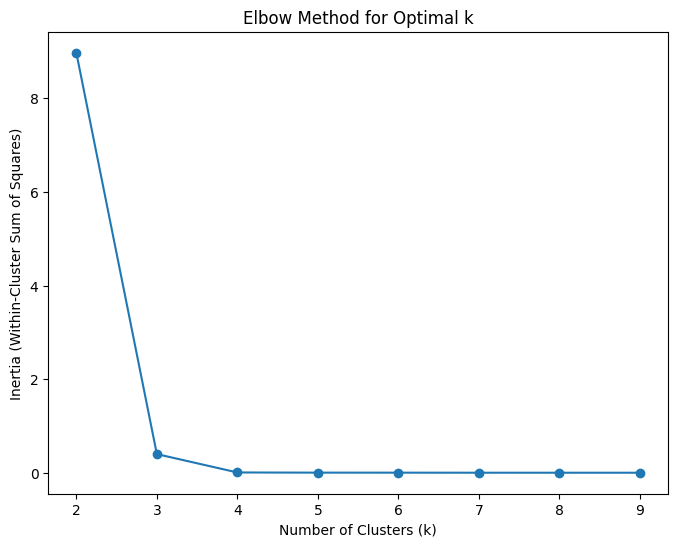

In [49]:
# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
# plt.savefig('elbow_curve.png')
plt.show()
# print("Elbow curve saved to 'elbow_curve.png'")

In [50]:
# Perform k-means clustering with k=3 (chosen from elbow method)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df['cluster'] = cluster_labels
print(cluster_labels)
df.head()



[2 1 1 0 1 1 1 1 0]


,ASIN,title,category,salesrank,review_count,avg_rating,co_purchases,log_salesrank,cluster
0,0060934719,Stardust,Book,7375,198,4.5,0380789019|0380789035|0060934700|0380977788|04...,8.905851,2
1,0689805330,Hannah and Jack,Book,1095476,1,5.0,NaN,13.906700,1
2,0671882201,Maiden of Inverness,Book,485399,5,4.0,0671730010|067188218X|0671882171|0671882198|06...,13.092727,1
3,157572328X,Papier Mache (Step By Step),Book,1425938,0,0.0,NaN,14.170340,0
4,6301394968,Sundown,Video,54951,6,4.0,B00074DY0M|B00000JN20|B00008LDNZ|B00023P4II|B0...,10.914197,1


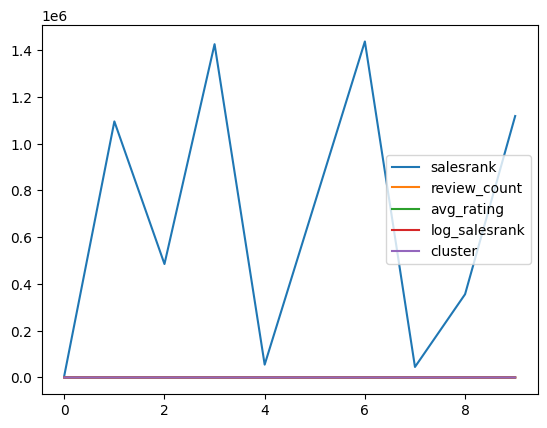

In [51]:
df.plot()

plt.show()

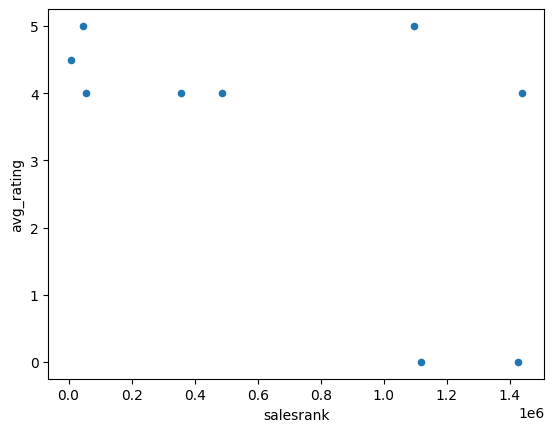

In [52]:
df.plot(kind = 'scatter', x='salesrank', y='avg_rating')

plt.show()

In [53]:
# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for k={k_optimal}: {silhouette_avg:.2f}")

Silhouette Score for k=3: 0.80


In [54]:
# Analyze cluster characteristics
cluster_summary = df.groupby('cluster').agg({
    'review_count': ['mean', 'count'],
    'avg_rating': 'mean',
    'category': lambda x: x.value_counts().index[0]  # Most common category
}).rename(columns={'<lambda>': 'top_category'})

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
        review_count       avg_rating     category
                mean count       mean top_category
cluster                                           
0           0.000000     2   0.000000         Book
1           4.166667     6   4.333333         Book
2         198.000000     1   4.500000         Book


In [55]:
# Infer cluster descriptions (manual interpretation)
cluster_descriptions = {
    0: "Low reviews, moderate ratings",
    1: "High-rated books",
    2: "Niche DVDs",
    3: "High review count, variable ratings",
    4: "Low-rated, few reviews"
}  # Adjust based on actual summary output

print("\nCluster Descriptions (Tentative):")
for i, desc in cluster_descriptions.items():
    print(f"Cluster {i}: {desc}")


Cluster Descriptions (Tentative):
Cluster 0: Low reviews, moderate ratings
Cluster 1: High-rated books
Cluster 2: Niche DVDs
Cluster 3: High review count, variable ratings
Cluster 4: Low-rated, few reviews


In [56]:
# Save results
df[['ASIN', 'review_count', 'avg_rating', 'category', 'cluster']].to_csv("clustered_data.csv", index=False)
with open("clustering_results.txt", "w") as f:
    f.write(f"Silhouette Score for k={k_optimal}: {silhouette_avg:.2f}\n\n")
    f.write("Cluster Summary:\n")
    f.write(cluster_summary.to_string())
    f.write("\n\nCluster Descriptions (Tentative):\n")
    for i, desc in cluster_descriptions.items():
        f.write(f"Cluster {i}: {desc}\n")
print("Results saved to 'clustered_data.csv' and 'clustering_results.txt'")

Results saved to 'clustered_data.csv' and 'clustering_results.txt'


In [57]:
import plotly.express as px
# df = pd.read_csv("amazon_sample_cleaned.csv")
# df = df[df['salesrank'] != -1]
df['avg_rating'] = df['avg_rating'].fillna(0)
fig = px.scatter(
    df,
    x='review_count',
    y='salesrank',
    color='avg_rating',
    size='review_count',  # Bubble size reflects review volume
    facet_col='category',  # Separate by category
    hover_data=['ASIN', 'title'],
    log_x=True,  # Log scale for review_count (long-tailed)
    title="Sales Rank vs. Review Count by Category",
    labels={'salesrank': 'Sales Rank (Lower is Better)', 'review_count': 'Review Count'}
)
fig.update_layout(height=600, width=1000)
fig.show()

In [58]:
import plotly.figure_factory as ff

df = df[df['salesrank'] != -1].fillna({'avg_rating': 0})
corr = df[['salesrank', 'review_count', 'avg_rating']].corr()
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=corr.columns.tolist(),
    y=corr.index.tolist(),
    annotation_text=corr.round(2).values,
    colorscale='RdBu',
    showscale=True
)
fig.update_layout(title="Feature Correlation Heatmap", width=600, height=600)
fig.show()

In [59]:
import plotly.express as px
fig = px.scatter(
    df,
    x='review_count',
    y='avg_rating',
    color='cluster',
    symbol='category',  # Different shapes per category
    hover_data=['ASIN', 'title'],
    log_x=True,  # Log scale for review_count
    title="Product Clusters by Review Count and Rating",
    labels={'review_count': 'Review Count (log scale)', 'avg_rating': 'Average Rating'}
)
fig.update_traces(marker=dict(size=10))
fig.update_layout(showlegend=True, width=1000, height=800)
fig.show()

In [60]:
import pandas as pd
edges = []
for _, row in df.iterrows():
    if row['co_purchases'] and isinstance(row['co_purchases'], str):
        targets = row['co_purchases'].split('|')
        for target in targets:
            edges.append((row['ASIN'], target))
edge_df = pd.DataFrame(edges, columns=['Source', 'Target'])
# edge_df.to_csv("co_purchase_edges.csv", index=False)


from IPython.display import display
styled_df = edge_df.style.set_properties(**{'text-align': 'left'})\
                         .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
display(styled_df)

,Source,Target
0,0060934719,0380789019
1,0060934719,0380789035
2,0060934719,0060934700
3,0060934719,0380977788
4,0060934719,0441003257
5,0671882201,0671730010
6,0671882201,067188218X
7,0671882201,0671882171
8,0671882201,0671882198
9,0671882201,067177932X


In [61]:
import plotly.express as px
df = df[df['salesrank'] != -1]
fig = px.box(
    df,
    x='cluster',
    y='salesrank',
    color='cluster',
    title="Sales Rank Distribution by Cluster",
    labels={'salesrank': 'Sales Rank (Lower is Better)', 'cluster': 'Cluster ID'}
)
fig.update_layout(yaxis_type="log", showlegend=False, width=800, height=600)
fig.show()

In [62]:
import pandas as pd
import networkx as nx
import plotly.express as px
from IPython.display import display
import matplotlib.pyplot as plt


df = df[df['salesrank'] != -1].fillna({'avg_rating': 0})

# Extract co-purchase edges
edges = []
for _, row in df.iterrows():
    if pd.notna(row['co_purchases']) and row['co_purchases']:
        targets = row['co_purchases'].split('|')
        for target in targets:
            edges.append((row['ASIN'], target))
edge_df = pd.DataFrame(edges, columns=['Source', 'Target'])

# Step 2: Build co-purchase network
G = nx.from_pandas_edgelist(edge_df, source='Source', target='Target', create_using=nx.Graph())

# Add node attributes (ratings, category, salesrank)
node_attrs = df.set_index('ASIN')[['avg_rating', 'category', 'salesrank', 'review_count']].to_dict('index')
nx.set_node_attributes(G, {asin: attrs for asin, attrs in node_attrs.items() if asin in G.nodes})

# Step 3: Network analytics
# 3.1: Degree distribution (co-purchase frequency)
degrees = dict(G.degree())
df_nodes = pd.DataFrame({
    'ASIN': list(degrees.keys()),
    'Degree': list(degrees.values())
}).merge(df[['ASIN', 'avg_rating', 'category', 'salesrank', 'review_count']], on='ASIN', how='left')

print("Top 5 Products by Co-Purchase Degree:")
display(df_nodes.sort_values('Degree', ascending=False).head())

# 3.2: Clustering coefficient (local network density)
clustering_coeffs = nx.clustering(G)
df_nodes['Clustering_Coeff'] = df_nodes['ASIN'].map(clustering_coeffs)

# Step 4: Statistical analysis
# 4.1: Correlation between degree, ratings, and salesrank
corr_matrix = df_nodes[['Degree', 'avg_rating', 'salesrank', 'review_count']].corr()
print("\nCorrelation Matrix:")
display(corr_matrix)

# Step 5: Visualizations
# 5.1: Scatter plot - Degree vs. Sales Rank, colored by Rating
# fig1 = px.scatter(
#     df_nodes,
#     x='Degree',
#     y='salesrank',
#     color='avg_rating',
#     size='review_count',
#     hover_data=['ASIN', 'category'],
#     log_y=True,  # Log scale for salesrank
#     title="Co-Purchase Degree vs. Sales Rank by Rating",
#     labels={'Degree': 'Co-Purchase Connections', 'salesrank': 'Sales Rank (Lower is Better)'}
# )
# fig1.update_layout(width=800, height=600)
# # Fix: Fill NaN values in 'review_count' with 0 before plotting
# fig1.update_traces(marker=dict(size=df_nodes['review_count'].fillna(0)))

# fig1.show()




Top 5 Products by Co-Purchase Degree:


,ASIN,Degree,avg_rating,category,salesrank,review_count
0,0060934719,5,4.5,Book,7375.0,198.0
6,0671882201,5,4.0,Book,485399.0,5.0
12,6301394968,5,4.0,Video,54951.0,6.0
18,0618070214,5,4.0,Book,356223.0,8.0
24,0688175201,5,0.0,Book,1118493.0,0.0



Correlation Matrix:


,Degree,avg_rating,salesrank,review_count
Degree,1.0,NaN,NaN,NaN
avg_rating,NaN,1.000000,-0.920151,0.390521
salesrank,NaN,-0.920151,1.000000,-0.522208
review_count,NaN,0.390521,-0.522208,1.000000


In [63]:
# 5.2: Bar plot - Average Rating by Top Co-Purchase Categories
top_categories = df_nodes.groupby('category').agg({'Degree': 'sum'}).nlargest(5, 'Degree').index
category_ratings = df_nodes[df_nodes['category'].isin(top_categories)].groupby('category').agg({
    'avg_rating': 'mean',
    'Degree': 'sum'
}).reset_index()
fig2 = px.bar(
    category_ratings,
    x='category',
    y='avg_rating',
    text=category_ratings['avg_rating'].round(2),
    title="Average Rating by Top Co-Purchase Categories",
    labels={'avg_rating': 'Average Rating (0-5)'}
)
fig2.update_traces(textposition='auto')
fig2.show()



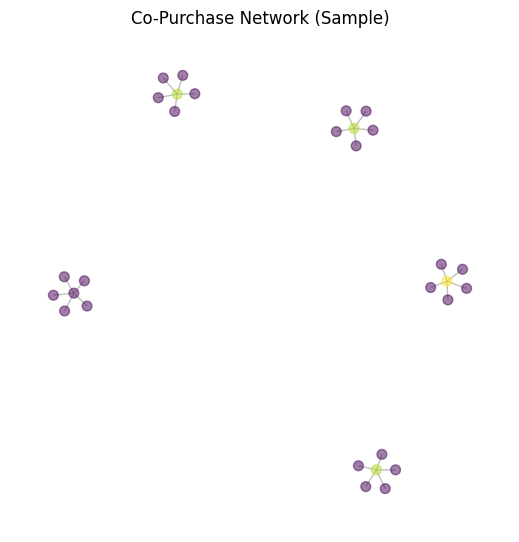

In [72]:
# 5.3: Network visualization (simplified for sample)
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, k=0.1)  # Simple layout for small sample
nx.draw(G, pos, node_size=50, node_color=[node_attrs.get(n, {}).get('avg_rating', 0) for n in G.nodes()],
        cmap=plt.cm.viridis, with_labels=False, edge_color='gray', alpha=0.5)
# plt.colorbar(label='Average Rating')
plt.title("Co-Purchase Network (Sample)")
plt.show()
plt.close()

# Step 6: Save results
# df_nodes.to_csv("co_purchase_analytics.csv", index=False)

In [65]:
# Step 1: Import necessary libraries
import pandas as pd
import networkx as nx
import plotly.express as px
import plotly.io as pio
from IPython.display import display
import matplotlib.pyplot as plt
from google.colab import files

# Step 2: Upload and load the dataset
# print("Please upload your dataset (e.g., amazon_sample_cleaned.csv)")
# uploaded = files.upload()  # Upload the dataset file
# df = pd.read_csv(list(uploaded.keys())[0])  # Load the uploaded file

# Step 3: Clean and preprocess the data
# Remove invalid salesrank entries and fill missing ratings with 0
df = df[df['salesrank'] != -1].fillna({'avg_rating': 0})

# Extract co-purchase edges
edges = []
for _, row in df.iterrows():
    if pd.notna(row['co_purchases']) and row['co_purchases']:
        targets = row['co_purchases'].split('|')
        for target in targets:
            edges.append((row['ASIN'], target))
edge_df = pd.DataFrame(edges, columns=['Source', 'Target'])

# Step 4: Build co-purchase network
G = nx.from_pandas_edgelist(edge_df, source='Source', target='Target', create_using=nx.Graph())

# Add node attributes (ratings, category, salesrank, review_count)
node_attrs = df.set_index('ASIN')[['avg_rating', 'category', 'salesrank', 'review_count']].to_dict('index')
nx.set_node_attributes(G, {asin: attrs for asin, attrs in node_attrs.items() if asin in G.nodes})

# Step 5: Network analytics
# 5.1: Degree distribution (co-purchase frequency)
degrees = dict(G.degree())
df_nodes = pd.DataFrame({
    'ASIN': list(degrees.keys()),
    'Degree': list(degrees.values())
}).merge(df[['ASIN', 'avg_rating', 'category', 'salesrank', 'review_count']], on='ASIN', how='left')

print("Top 5 Products by Co-Purchase Degree:")
display(df_nodes.sort_values('Degree', ascending=False).head())



Top 5 Products by Co-Purchase Degree:


,ASIN,Degree,avg_rating,category,salesrank,review_count
0,0060934719,5,4.5,Book,7375.0,198.0
6,0671882201,5,4.0,Book,485399.0,5.0
12,6301394968,5,4.0,Video,54951.0,6.0
18,0618070214,5,4.0,Book,356223.0,8.0
24,0688175201,5,0.0,Book,1118493.0,0.0


In [66]:
# 5.2: Clustering coefficient (local network density)
clustering_coeffs = nx.clustering(G)
df_nodes['Clustering_Coeff'] = df_nodes['ASIN'].map(clustering_coeffs)

# Step 6: Statistical analysis
# 6.1: Correlation between degree, ratings, salesrank, and review count
corr_matrix = df_nodes[['Degree', 'avg_rating', 'salesrank', 'review_count']].corr()
print("\nCorrelation Matrix:")
display(corr_matrix)




Correlation Matrix:


,Degree,avg_rating,salesrank,review_count
Degree,1.0,NaN,NaN,NaN
avg_rating,NaN,1.000000,-0.920151,0.390521
salesrank,NaN,-0.920151,1.000000,-0.522208
review_count,NaN,0.390521,-0.522208,1.000000


In [67]:
# Step 7: Visualizations
# 7.1: Scatter plot - Degree vs. Sales Rank, colored by Rating
fig1 = px.scatter(
    df_nodes,
    x='Degree',
    y='salesrank',
    color='avg_rating',
    size='review_count',
    hover_data=['ASIN', 'category'],
    log_y=True,  # Log scale for salesrank due to wide range
    title="Co-Purchase Degree vs. Sales Rank by Rating",
    labels={'Degree': 'Co-Purchase Connections', 'salesrank': 'Sales Rank (Lower is Better)'}
)
# Fix: Fill NaN values in 'review_count' with 0 before plotting
# fig1.update_traces(marker=dict(size=df_nodes['review_count'].fillna(0))) # Fill NaN with 0 for marker size

pio.show(fig1)  # Display the plot directly in Colab


ValueError: 
    Invalid element(s) received for the 'size' property of scatter.marker
        Invalid elements include: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

In [68]:

# 7.2: Bar plot - Average Rating by Top Co-Purchase Categories
top_categories = df_nodes.groupby('category').agg({'Degree': 'sum'}).nlargest(5, 'Degree').index
category_ratings = df_nodes[df_nodes['category'].isin(top_categories)].groupby('category').agg({
    'avg_rating': 'mean',
    'Degree': 'sum'
}).reset_index()
fig2 = px.bar(
    category_ratings,
    x='category',
    y='avg_rating',
    text=category_ratings['avg_rating'].round(2),
    title="Average Rating by Top Co-Purchase Categories",
    labels={'avg_rating': 'Average Rating (0-5)'}
)
fig2.update_traces(textposition='auto')
pio.show(fig2)  # Display the plot directly in Colab


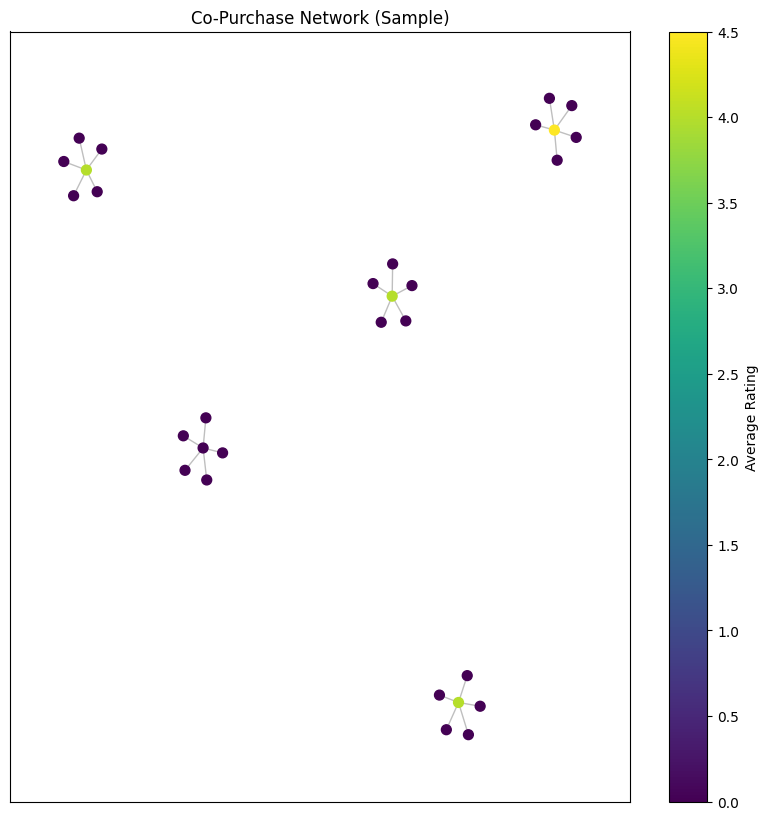

In [71]:
# 7.3: Network visualization (simplified for sample)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.1)  # Simple layout for small sample

# Get node colors based on 'avg_rating'
node_colors = [node_attrs.get(n, {}).get('avg_rating', 0) for n in G.nodes()]

# Create a color map
cmap = plt.cm.viridis

# Draw the network with the specified node colors and color map
nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=cmap)

# Draw the edges
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Create the colorbar and associate it with the nodes
plt.colorbar(nodes, label='Average Rating')

plt.title("Co-Purchase Network (Sample)")
plt.show()  # Display the plot directly in Colab
plt.close()